# Lab 4:  Data preprocessing

We explore the performance of several linear regression models on a real-world dataset, i.e. [MoneyBall](https://www.openml.org/d/41021). See the description on OpenML for more information. In short, this dataset captures performance data from baseball players. The regression task is to accurately predict the number of 'runs' each player can score, and understanding which are the most important factors.

In [1]:
# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [ ]:
# Download MoneyBall data from OpenML
moneyball = oml.datasets.get_dataset(41021)
# Get the pandas dataframe (default)
X, y, _, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute)

## Exploratory analysis and visualization
First, we visually explore the data by visualizing the value distribution and the interaction between every other feature in a scatter matrix. We use the target feature as the color variable to see which features are correlated with the target.

For the plotting to work, however, we need to remove the categorical features (the first 2) and fill in the missing values. Let's find out which columns have missing values. This matches what we already saw on the OpenML page (https://www.openml.org/d/41021).

In [3]:
pd.isnull(X).any()

Team            False
League          False
Year            False
RA              False
W               False
OBP             False
SLG             False
BA              False
Playoffs        False
RankSeason       True
RankPlayoffs     True
G               False
OOBP             True
OSLG             True
dtype: bool

In [4]:
X.shape

(1232, 14)

For this first quick visualization, we will simply impute the missing values using the median. Removing all instances with missing values is not really an option since some features have consistent missing values: we would have to remove a lot of data.

In [5]:
# Impute missing values with sklearn and rebuild the dataframe
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_clean_array = imputer.fit_transform(X[attribute_names[2:]]) # skip the first 2 features
# The imputer will return a numpy array. To plot it we make it a pandas dataframe again.
X_clean = pd.DataFrame(X_clean_array, columns = attribute_names[2:]) #

Next, we build the scatter matrix. We include the target column to see which features strongly correlate with the target, and also use the target value as the color to see which combinations of features correlate with the target.

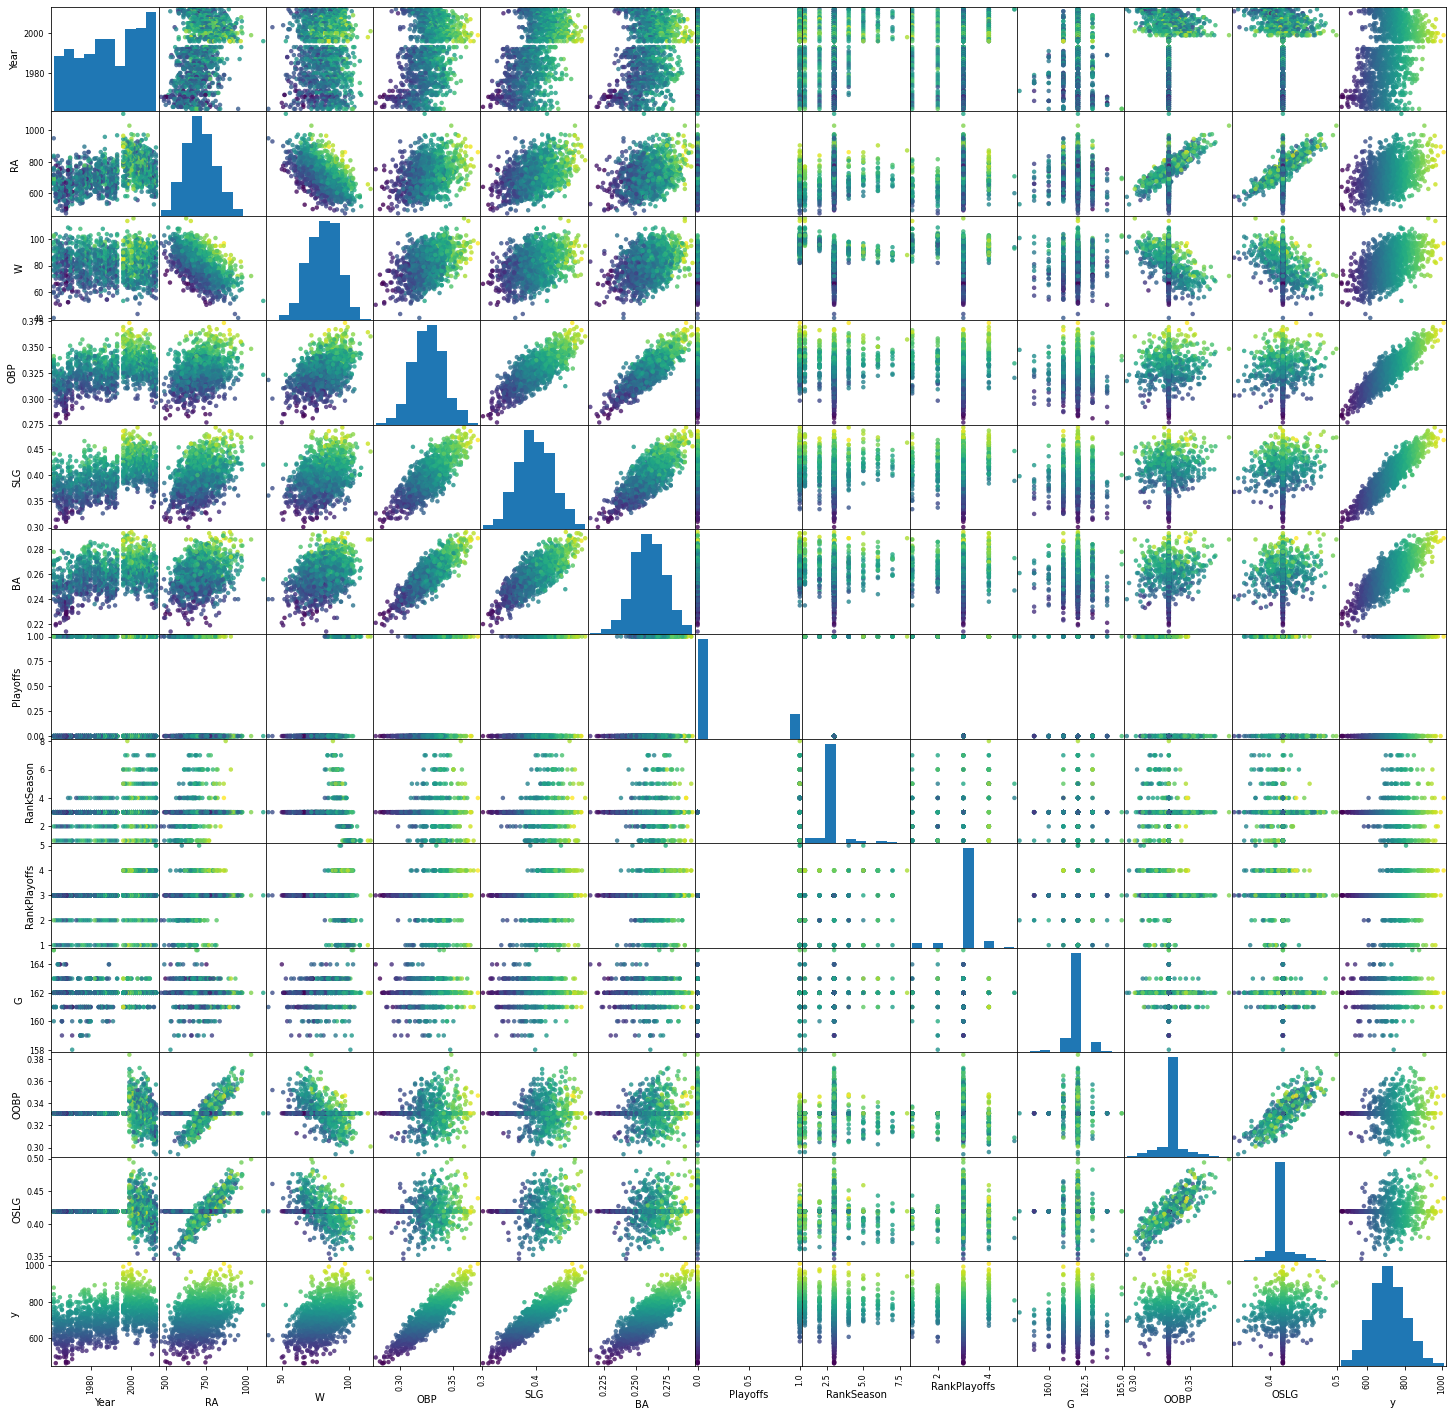

In [6]:
from pandas.plotting import scatter_matrix

# Scatter matrix of dataframe including the target feature
copyframe = X_clean.copy() 
copyframe['y'] = pd.Series(y, index=copyframe.index)
scatter_matrix(copyframe, c=y, figsize=(25,25), 
               marker='o', s=20, alpha=.8, cmap='viridis');

Several things immediately stand out:
* OBP, SLG and BA strongly correlate with the target (near-diagonals in the final column), but also combinations of either of these and W or R seem useful.
* RA, W, OBP, SLG and BA seem normally distributed, most others do not. 
* OOBP and OSLG have a very peaked distribution. 
* 'Playoffs' seems to be categorical and should probably be encoded as such. 

In [126]:
np.random.seed(1111123)
idxs = np.arange(0, X.shape[0])
np.random.shuffle(idxs)

X, y = X.iloc[idxs], y[idxs]

## Exercise 1: Build a pipeline

Implement a function `build_pipeline` that does the following:
- Impute missing values by replacing NaN's with the feature median for numerical features.
- Encode the categorical features using OneHotEncoding.
- If the attribute `scaling=True`, also scale the data using standard scaling.
- Attach the given regression model to the end of the pipeline

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 


def build_pipeline(regressor, numerical, categorical, scaling=False):
    """ Build a robust pipeline with the given regression model
    Keyword arguments:
    regressor -- the regression model
    categorical -- the list of categorical features
    scaling -- whether or not to scale the data
    
    Returns: a pipeline
    """
    
    steps = []
    
    numerical_preprocessor = [("imputer", SimpleImputer(strategy="median"))]
    if scaling:
        numerical_preprocessor.append(("scaler", StandardScaler()))
        
    categorical_preprocessor = [("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
    
    preprocessor = ColumnTransformer([("numerical", Pipeline(numerical_preprocessor), numerical),
                                     ("categorical", Pipeline(categorical_preprocessor), categorical)])
    
    steps.append(("preprocessor", preprocessor))
        
    steps.append(("regressor", regressor))
    
    return Pipeline(steps)
    
    

In [9]:
categorical = ["Team", "League"]
numerical = [name for name in X.columns if name not in categorical]

## Exercise 2: Test the pipeline
Test the pipeline by evaluating linear regression (without scaling) on the dataset, using 5-fold cross-validation and $R^2$. Make sure to run it on the original dataset ('X'), not the manually cleaned version ('X_clean').

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from IPython.display import display, Markdown, Latex

pipeline = build_pipeline(LinearRegression(), numerical, categorical)
scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
display(Markdown(f"LSE $R^2$: {np.mean(scores):.3f}({np.std(scores):.3f})"))

LSE $R^2$: 0.946(0.005)

In [11]:
# Just to see it works, for lse scaling does not change anything in optimization
pipeline = build_pipeline(LinearRegression(), numerical, categorical, True)
scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
display(Markdown(f"LSE $R^2$: {np.mean(scores):.3f}({np.std(scores):.3f})"))

LSE $R^2$: 0.946(0.005)

## Exercise 3: A first benchmark
Evaluate the following algorithms in their default settings, both with and without scaling, and interpret the results:  
- Linear regression
- Ridge
- Lasso
- SVM (RBF)
- RandomForests
- GradientBoosting

In [12]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


models = [LinearRegression(), Ridge(), Lasso(), SVR(kernel="rbf"), RandomForestRegressor(), GradientBoostingRegressor()]

results = []
for m in models:
    results.append([m.__class__.__name__])
    for scaling in [0, 1]:
    
        pipeline = build_pipeline(m, numerical, categorical, scaling)
        scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
        
        results[-1].append(f"{np.mean(scores):.3f}({np.std(scores):.3f})")
        

results = pd.DataFrame(results, columns=["model", "r2 - no scaling", "r2 - scaling"])
results

model r2 - no scaling  r2 - scaling
0           LinearRegression    0.946(0.005)  0.946(0.005)
1                      Ridge    0.884(0.006)  0.946(0.005)
2                      Lasso    0.858(0.009)  0.945(0.005)
3                        SVR    0.006(0.002)  0.574(0.023)
4      RandomForestRegressor    0.928(0.008)  0.928(0.007)
5  GradientBoostingRegressor    0.939(0.006)  0.939(0.006)

* There are models with $R^2$ around 0.95 which is good.
* Linear Regression and Tree Ensembles are invariant to scaling, so their results are identical.
* Ridge and Lasso get better results, when scaling is applied. This is understandable, as Ridge and Lasso have penalty parameter, which is same for all weights, thus if weights have different scales, it is hard to choose this penalty right.
* SVR is as bad as mean prediction without scaling, and gets much better result when scaling is used. Still obtained $R^2$ is by far the worst among all other models, this may be due to $C$ and $\gamma$ parameters not tuned to the data.

## Exercise 4: Tuning linear models
Next, visualize the effect of the alpha regularizer for Ridge and Lasso. Vary alpha from 1e-4 to 1e6 and plot the $R^2$ score as a line plot (one line for each algorithm). Always use scaling. Interpret the results.

In [13]:
from sklearn.model_selection import GridSearchCV

params = {"regressor__alpha": np.logspace(-4, 6, 10)}


searches = [GridSearchCV(build_pipeline(m, numerical, categorical, True),
                         params, 
                         cv=5, 
                         scoring="r2",
                         n_jobs=-1) for m in [Ridge(), Lasso()]]

In [14]:
for s in searches:
    s.fit(X, y)

In [16]:
for s in searches:
    print(f"{s.best_estimator_['regressor'].__class__.__name__}: {s.best_params_}")

Ridge: {'regressor__alpha': 0.21544346900318845}
Lasso: {'regressor__alpha': 0.21544346900318845}


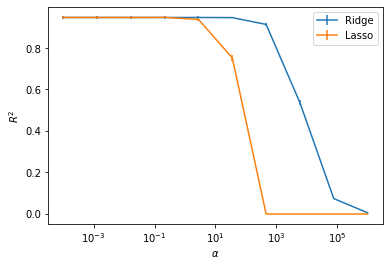

In [17]:
for s in searches:
    plt.errorbar(params["regressor__alpha"], s.cv_results_["mean_test_score"],
                 yerr=s.cv_results_["std_test_score"],
                 label=s.best_estimator_["regressor"].__class__.__name__)

plt.xscale("log")
plt.ylabel("$R^2$")
plt.xlabel("$\\alpha$")
plt.legend()
plt.show()

* In general both fit the data quite well with small $\alpha$. As it gets bigger, models become more regularized and start to severely underfit.
* Std deviations of cv scores are very small, thus optimal $\alpha$ seems to be universal(not very dependent on training data).
* Lasso starts underfitting much earlier, as its penalty is more harsh when data is standarized(and so are the weights).

## Exercise 5: Tuning SVMs
Next, tune the SVM's C and gamma. You can stay within the 1e-6 to 1e6 range. Plot the $R^2$ score as a heatmap.

In [116]:
from matplotlib.pyplot import figure

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    
    figure(figsize=(8, 8), dpi=80)
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [19]:
def build_grid_search(scaling):
    
    params = {"regressor__C": np.logspace(-6, 6, 10),
              "regressor__gamma": np.logspace(-6, 6, 10)}
    return GridSearchCV(build_pipeline(SVR(kernel="rbf"), numerical, categorical, scaling),
                        params, 
                        cv=5, 
                        scoring="r2",
                        n_jobs=-1)

In [20]:
search_not_scaled = build_grid_search(False)
search_not_scaled.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Year',
                                                                          'RA',
                                                                          'W',
                                                                          'OBP',
                                                                          'SLG',
                                                                          'BA',
                                                                          'Playoffs',
                                          

In [22]:
print(search_not_scaled.best_params_)

{'regressor__C': 1000000.0, 'regressor__gamma': 2.1544346900318823e-05}


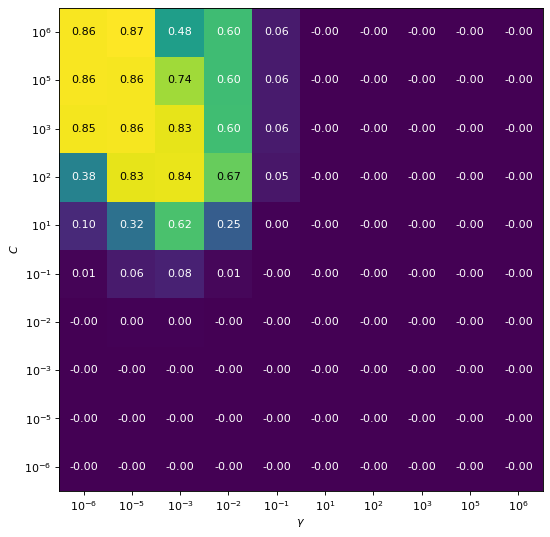

In [117]:
heatmap(search_not_scaled.cv_results_["mean_test_score"].reshape(10, 10), 
        "$\gamma$",
        "$C$",
        [f"$10^{{ {i:.0f} }}$" for i in np.linspace(-6, 6, 10)],
        [f"$10^{{ {i:.0f} }}$" for i in np.linspace(-6, 6, 10)]
        )
plt.show()

* Model is able to reach $R^2$ of 0.86, which is much better than with default parameters(which was around 0).
* Optimal $C$ and $\gamma$ are placed at borders of params grid, this may suggest the more optimal values stayed outside of the grid.

## Exercise 5b: Tuning SVMs (2)
Redraw the heatmap, but now use scaling. What do you observe?

In [129]:
search_scaled = build_grid_search(True)
search_scaled.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Year',
                                                                          'RA',
                                                                          'W',
                                                                          'OBP',
                                                                          'SLG',

In [130]:
print(search_scaled.best_params_)

{'regressor__C': 2154.434690031878, 'regressor__gamma': 0.00046415888336127773}


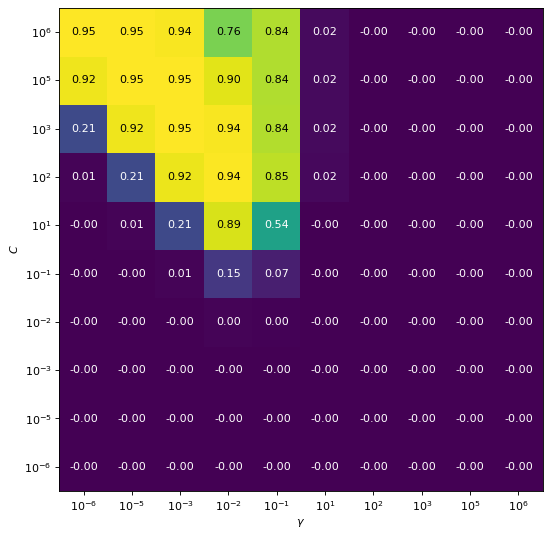

In [131]:
heatmap(search_scaled.cv_results_["mean_test_score"].reshape(10, 10), 
        "$\gamma$",
        "$C$",
        [f"$10^{{ {i:.0f} }}$" for i in np.linspace(-6, 6, 10)],
        [f"$10^{{ {i:.0f} }}$" for i in np.linspace(-6, 6, 10)]
        )
plt.show()

* Area with more or less big $R^2$ is now bigger. Also values of $R^2$ are now much higher.
* Ones of the best values are still obtained at grid border. For further improvements one may want to increase upper $C$ border and decrease lower $\gamma$ border.

## Exercise 6: Feature importance 
Retrieve the coefficients from the optimized Lasso, Ridge, and the feature importances from the default RandomForest and GradientBoosting models.
Compare the results. Do the different models agree on which features are important? You will need to map the encoded feature names to the correct coefficients and feature importances. If you can, plot the importances as a bar chart.

In [134]:
models = [searches[0].best_estimator_,
          searches[1].best_estimator_,
          build_pipeline(RandomForestRegressor(), numerical, categorical).fit(X, y),
          build_pipeline(GradientBoostingRegressor(), numerical, categorical).fit(X, y)]

In [166]:
importances = [models[0]["regressor"].coef_,
               models[1]["regressor"].coef_,
               models[2]["regressor"].feature_importances_,
               models[3]["regressor"].feature_importances_]

In [208]:
features_names = X.columns[2:].tolist()
features_names += models[-1]["preprocessor"].named_transformers_["categorical"]["ohe"].get_feature_names_out().tolist()
features_names = np.array(features_names)
print(features_names)

['Year' 'RA' 'W' 'OBP' 'SLG' 'BA' 'Playoffs' 'RankSeason' 'RankPlayoffs'
 'G' 'OOBP' 'OSLG' 'Team_ANA' 'Team_ARI' 'Team_ATL' 'Team_BAL' 'Team_BOS'
 'Team_CAL' 'Team_CHC' 'Team_CHW' 'Team_CIN' 'Team_CLE' 'Team_COL'
 'Team_DET' 'Team_FLA' 'Team_HOU' 'Team_KCA' 'Team_KCR' 'Team_LAA'
 'Team_LAD' 'Team_MIA' 'Team_MIL' 'Team_MIN' 'Team_MLN' 'Team_MON'
 'Team_NYM' 'Team_NYY' 'Team_OAK' 'Team_PHI' 'Team_PIT' 'Team_SDP'
 'Team_SEA' 'Team_SEP' 'Team_SFG' 'Team_STL' 'Team_TBD' 'Team_TBR'
 'Team_TEX' 'Team_TOR' 'Team_WSA' 'Team_WSN' 'League_AL' 'League_NL']


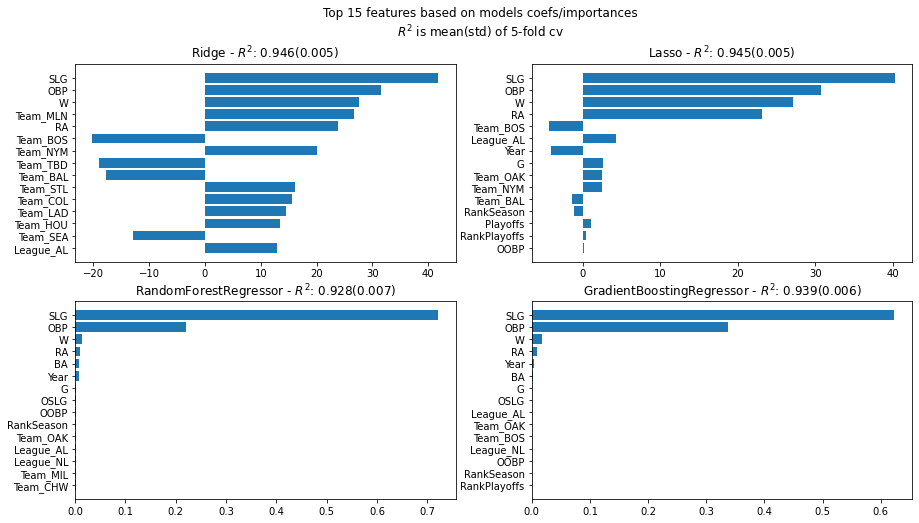

In [226]:
topn = 15

models_names = results["model"].tolist()
models_cv_scores = results["r2 - scaling"].tolist()

fig, axs = plt.subplots(2, 2)

fig.set_size_inches(15, 8)

for i in range(2):
    idxs = np.argsort(-np.abs(importances[i]))[:topn]
    axs[0, i].barh(features_names[idxs][::-1], importances[i][idxs][::-1])
    j = models_names.index(models[i]["regressor"].__class__.__name__)
    axs[0, i].set_title(f"{models_names[j]} - $R^2$: {models_cv_scores[j]}")
    
for i in range(2, 4):
    idxs = np.argsort(-importances[i])[:topn]
    axs[1, i-2].barh(features_names[idxs][::-1], importances[i][idxs][::-1])
    j = models_names.index(models[i]["regressor"].__class__.__name__)
    axs[1, i-2].set_title(f"{models_names[j]} - $R^2$: {models_cv_scores[j]}")

fig.suptitle(f"Top {topn} features based on models coefs/importances\n$R^2$ is mean(std) of 5-fold cv")
plt.show()

* Top 3 variables for each model are identical(even their order). Theese are the ones correlated with the target.
* Tree ensambles had a few(2) features with high importances, whereas regression models had more(4-5).
* Expectedly, Lasso had way less features with big coefficients than Ridge.